*This is a Jupyter Notebook. It is an interactive document that contains both rich text elements such as figures, links, equations, etc. and executable code - in this case Python code (the grey boxes).
**How to use a Jupyter Notebook**: You can execute the blocks of code one at the time by placing the mouse in the grey box and pressing shift + enter. An asterisk will appear in the brackets at the top left of the box while the code is being executed (this may take few seconds) and turns into a number when the execution is over. Alternatively, you can run all the code in the Notebook in a single step by clicking on the menu Cell -> Run All.*

# GSA tutorial - What are the most important parameters in a mathematical model?
Francesca Pianosi, Fanny Sarrazin, Andres Peñuela

Mathematical models often encompass a large number of parameters. The value of these parameters for a particular application are decided by the modeller based on information about the quantities that these parameters represent (for example, measurements from field work or from lab experiments). Alternatively, if the modeller possesses some observations of the system' input and output variables, the parameterss can be estimated by finding the values that makes the model best fit those observations (this process is called *model calibration*). 
In both cases, determining the 'right' parameter values is often difficult and time consuming, as it may require acquiring and handling a lot of data and/or using of a lot of computing power (if the model is calibrated using a computer algorithm). In this Notebook we see how Global Sensitivity Analysis (GSA) can help in this context, by allowing us to determine the relative importance of the parameters on the model predictions, and therefore identify the most influential parameters on which estimation efforts should be focused on.

# A hydrological example

In this Notebook we will apply GSA to determine the influential and uninfluential parameters of a hydrological model. A hydrological model takes time series of meteorological forcings (rainfall and temperature) over a river basin, and returns the time series of river flows at the basin outlet. For the sake of illustration, here we will use a very simple model, the Hymod model (Boyle 2001; Wagener et al. 2001), which only has five parameters. These parameters represent some key basin characteristics that determine the transformation of rainfall into flow, such as the soil's water holding capacity and the velocity with which water travels in the sub-surface. 
We will apply the model to the Leaf catchment in the USA (Sorooshian et al., 1983), for which we possess daily observations of rainfall (R), potential evaporation (PE) and river flow (Q), which can be used for the model calibration. Specifically, we will measure the model's fit-to-data with two performance metrics: the Root Mean Squared Error (RMSE) and the volumetric bias (BIAS). We will show how GSA can be used to quantify the relative importance of the five model parameters in controlling these performance metrics. 

<left><img src="hyd/Hymod_fig.png" width="700px">
   
### Programme
1. Model setup. Load the data and get familiar with the Hymod rainfall-runoff model through a One-At-the-Time Sensitivity Analysis
2. Monte Carlo simulation (forward propagation of uncertainty): sample the model parameter within their ranges and run the model to obtain an ensemble of river flow predictions. 
3. Global Sensitivity Analysis using the PAWN method (backward attribution of uncertainty): use PAWN (Pianosi and Wagener, 2018) to formally assess the effect of parameter variations on the output metrics (RMSE and BIAS).

## 1 - Model setup and One-At-the-Time Sensitivity Analysis

### Import libraries

In [2]:
from __future__ import division, absolute_import, print_function

import sys
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatRangeSlider, IntRangeSlider
import scipy.stats as st
import warnings
warnings.filterwarnings('ignore') # to hide warning messages
# Module to perform PAWN:
import safepython.PAWN as PAWN
# Module to visualize the results:
import safepython.plot_functions as pf
# Module to execute the model
from safepython.model_execution import model_execution
# Functions to perform the input sampling
from safepython.sampling import AAT_sampling, AAT_sampling_extend
# Function to calculate RMSE:
from safepython.util import aggregate_boot, RMSE
# Module that simulates the HyMod model:
from safepython import HyMod

# Import the additional function BIAS in the BIAS.py module
from hyd.BIAS import BIAS as BIAS

### Load and plot data

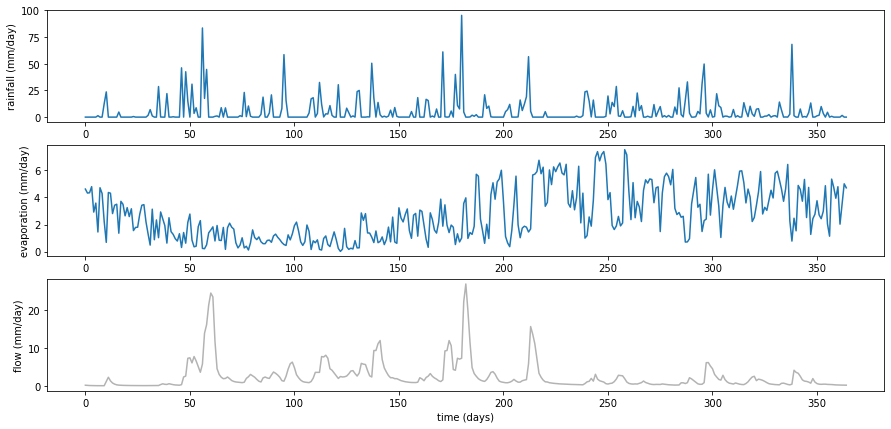

In [6]:
# Load data (one year of daily observations of rainfall, potential evaporation and flow):
data = np.genfromtxt('hyd/LeafCatch.txt', comments='%')
rain = data[0:365, 0] # select the first year of data
evap = data[0:365, 1]
flow = data[0:365, 2]
warmup = 30 # Model warmup period (days)

# Plot data:
plt.figure(figsize=[15,7])
plt.subplot(311); plt.plot(rain); plt.ylabel('rainfall (mm/day)')
plt.subplot(312); plt.plot(evap); plt.ylabel('evaporation (mm/day)')
plt.subplot(313); plt.plot(flow, color=[0.7, 0.7, 0.7]); plt.ylabel('flow (mm/day)')
plt.xlabel('time (days)')
plt.show()

### One-At-the-Time Sensitivity Analysis
We are now ready to run the Hymod model. To do this, we will set the five model parameters to some tentative values, run the model and plot the resulting streamflow time series. We can then change the parameter values one-at-a-time and look at how this changes the model predictions, and their fit to observed flows.

In [7]:
# Define interactive visualisation function to set the parameters to some tentative values, 
# run the model and plot the resulting streamflow time series

def oat_function(Sm = 200, beta = 0.5, alpha = 0.7, Rs = 0.05, Rf = 0.6):
    # Set a tentative parameterization:
    param = np.array([Sm, beta, alpha, Rs, Rf]) # Sm (mm), beta (-), alfa (-), Rs (-), Rf (-)
    # Run simulation:
    flow_sim, _, _ = HyMod.hymod_sim(param, rain, evap)
    # Plot results:
    plt.figure(figsize=[15,3])
    plt.plot(flow, color=[0.7, 0.7, 0.7]) # observed flow
    plt.plot(flow_sim, 'k') # simulated flow
    plt.ylabel('flow (mm/day)')
    plt.xlabel('time (days)')
    plt.legend(['obs', 'sim'])
    plt.title("RMSE = %g" % RMSE(flow_sim[warmup:365],flow[warmup:365]) + " (mm/day) - BIAS = %g" % BIAS(flow_sim[warmup:365],flow[warmup:365]) + " (mm/day)" )
    plt.show()
    
interact(oat_function, Sm = (0, 400, 1), beta = (0, 2, 0.1), alpha = (0,1,0.1), Rs = (0,0.1,0.01), Rf = (0.1,1,0.1));

interactive(children=(IntSlider(value=200, description='Sm', max=400), FloatSlider(value=0.5, description='bet…

### Questions:

* What is the effect of varying each model parameter? [*Hydrology question: which parameter controls which characteristic (timing, peak, recession phase, etc.) of the simulated flow time series?*]
* Can you tell which parameters mostly control the model predictions and fit-to-observations?
* What are the pros and cons of OAT sensitivity analysis?

##  2 - Monte Carlo simulations and qualitative (visual) Global Sensitivity Analysis

In this section, we run Monte Carlo (MC) simulations of the model against a prescribed number of parameter combinations, randomly drawn from the feasible parameter ranges. Each model simulation provides a times series of streamflow predictions. For each time series, we will measure the distance from observations by means of a synthetic performance metric. Here we have implemented two possible metrics: the Root Mean Squared Error (RMSE) and the volumetric Bias (BIAS). The global sensitivity analysis can thus be repeated twice, once for RMSE and once for the BIAS.

### Run Monte Carlo simulations

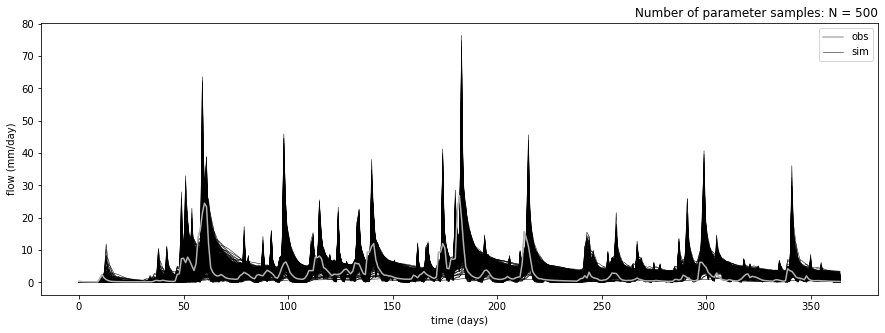

In [8]:
# Define input variability space:
X_Labels = ['Sm', 'beta', 'alfa', 'Rs', 'Rf'] # Name of parameters (used to customize plots)
M = len(X_Labels) # Number of parameters
distr_fun = st.uniform # Parameter distributions
xmin = [0, 0, 0, 0, 0.1] # Parameter ranges (lower bound)
xmax = [400, 2, 1, 0.1, 1] # Parameter ranges (upper bound)

# Save lower and upper bound in the appropriate format to be passed on to the sampling function:
distr_par = [np.nan] * M
for i in range(M):
    distr_par[i] = [xmin[i], xmax[i] - xmin[i]]

# Choose sampling strategy and size:
samp_strat = 'lhs' # sampling strategy
# options:
# 'lhs' = Latin Hypercube sampling
# 'rsu' = Random uniform sampling

# Choose the number of samples:
N = 500 

# Perform sampling:
X = AAT_sampling(samp_strat, M, distr_fun, distr_par, N)

# Execute the model against all the input samples in 'X':
QQ = model_execution(HyMod.hymod_sim, X, rain, evap)

# Plot Monte Carlo (MC) simulations results and compare with data:
plt.figure(figsize=[15,5])
plt.plot(flow, color=[0.7, 0.7, 0.7]) # plot for legend
plt.plot(np.transpose(QQ), 'k', linewidth = 0.5)
plt.plot(flow, color=[0.7, 0.7, 0.7])
plt.ylabel('flow (mm/day)'); plt.xlabel('time (days)')
plt.legend(['obs', 'sim'])
plt.title("Number of parameter samples: N = %d" % N, loc='right')
plt.show()

###  Aggregate time series into scalar output metric(s) and produce scatter plots:

In [9]:
# Calculate RMSE and BIAS for each parameter sample:
YY = np.nan * np.ones((N, 2))
YY[:, 0] = RMSE(QQ[:, warmup:365], flow[warmup:365])
YY[:, 1] = BIAS(QQ[:, warmup:365], flow[warmup:365])

# Define interactive visualisation function to produce scatter plots for the chosen output metrics:
def scatter_function(metric='RMSE'):
    if metric == 'RMSE':
        i = 0
    elif metric == 'BIAS':
        i = 1
            
    # Extract output metric:
    Y = YY[:, i]; 
    Y_Label = metric + '(mm/day)'

    # Scatter plots of the output metric against input samples:
    plt.figure(figsize=[15,3])
    pf.scatter_plots(X, Y, Y_Label=Y_Label, X_Labels=X_Labels)
    plt.title("Number of parameter samples: N = %d" % N, loc='right')
    plt.show()
    
interact(scatter_function, metric = ['RMSE','BIAS']);

interactive(children=(Dropdown(description='metric', options=('RMSE', 'BIAS'), value='RMSE'), Output()), _dom_…

### Questions:
* From these scatter plots, which parameter would you say is most influential? Why?
* How does the answer changes with the chosen performance metric? [*Hydrology question: can you interpret why certain parameters are more important for RMSE and others for BIAS?*]

## 3 - Global Sensitivity Analysis using the PAWN method
In this section, we formally assess the sensitivity of the performance metrics to the model parameters through the PAWN method (Pianosi and Wagener, 2018). Again, the analysis can be repeated twice, once for the RMSE and once for the BIAS. For each performance metric, we can also assess the impact of the choice of the tuning parameters of the PAWN method: the number of conditioning interval (n), the aggregation statistic (median, mean, max) and the number of bootstrap resamples (Nboot) used to estimate confidence intervals of the PAWN indices.

In [10]:
# Define interactive visualisation function to calculate and visualise sensitivity indices
# for the chosen output metric and different choices of the PAWN tuning parameters (n,Nboot,aggr)

def pawn_function(metric='RMSE', n = 5, aggr = 'median',Nboot = 500):
    # Extract output metric:
    if metric == 'RMSE':
        i = 0
    elif metric == 'BIAS':
        i = 1   
    Y = YY[:, i]; 
    
    # Apply PAWN
    # Tuning parameters:
    # n = number of conditioning intervals
    # aggr = statistic to aggregate KS values
    # Nboot = number of bootstrapping resamples used to derive confidence bounds of sensitivity indices   

    # Compute sensitivity indices for Nboot bootstrap resamples
    KS_median, KS_mean, KS_max = PAWN.pawn_indices(X, Y, n, Nboot=Nboot)
    # KS_median and KS_mean and KS_max have shape (Nboot, M)
        
    # Compute mean and confidence intervals of the sensitivity indices across the bootstrap resamples:
    KS_median_m, KS_median_lb, KS_median_ub = aggregate_boot(KS_median) # shape (M,)
    KS_mean_m, KS_mean_lb, KS_mean_ub = aggregate_boot(KS_mean) # shape (M,)
    KS_max_m, KS_max_lb, KS_max_ub = aggregate_boot(KS_max) # shape (M,)

    # Plot sensitivity indices:
    plt.figure()
    plt.title("Output metric = %s" % metric)
    if aggr == 'median':
        pf.boxplot1(KS_median_m, S_lb=KS_median_lb, S_ub=KS_median_ub, X_Labels=X_Labels, Y_Label='sensitivity (median KS)')
    if aggr == 'mean':
        pf.boxplot1(KS_mean_m, S_lb=KS_mean_lb, S_ub=KS_mean_ub, X_Labels=X_Labels, Y_Label='sensitivity (mean KS)')
    if aggr == 'max':
        pf.boxplot1(KS_max_m, S_lb=KS_max_lb, S_ub=KS_max_ub, X_Labels=X_Labels, Y_Label='sensitivity (max KS)')
    plt.show()
    
interact(pawn_function, metric = ['RMSE','BIAS'], n = (2, 20, 1), aggr = ['median', 'mean','max'], Nboot = (0, 500, 10));


interactive(children=(Dropdown(description='metric', options=('RMSE', 'BIAS'), value='RMSE'), IntSlider(value=…

### Questions:
* Which parameter are most influential on each performance metric? Are these results consistent with the visual inspection of the scatter plots?
* *Advanced GSA question: What is the impact of changing n and Nboot? Why?*

## References

Boyle, D. (2001). Multicriteria calibration of hydrological models. PhD thesis, Dep. of Hydrol. and Water Resour., Univ. of Ariz., Tucson.

Pianosi et al. (2015). A Matlab toolbox for Global Sensitivity Analysis’. Env. Mod. & Soft., 70, 80-85.

Pianosi and Wagener (2018). Distribution-based sensitivity analysis from a generic input-output sample, Env. Mod. & Soft., 108, 197-207.

Wagener, T., Boyle, D., Lees, M., Wheater, H., Gupta, H., and Sorooshian, S. (2001). A framework for development and application of hydrological models. Hydrol. Earth Syst. Sci., 5, 13-26.

Sorooshian at al. (1983). Evaluation of maximum likelihood parameter estimation techniques for conceptual rainfall-runoff models: Influence of calibration data variability and length on model credibility. Water Resour. Res., 19, 251–259.